<a href="https://colab.research.google.com/github/Tarun0956/ai_devops/blob/main/starter_notebook_2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S R
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

DATA_SOURCE_MAPPING = 'worksheet-2-slr:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F8152006%2F12885034%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20250903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20250903T130454Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7795196b50c799322e8efabd8e082410f7b2291b2f113ed75aaeccd375da49c789d56b2d8a5f4fdc0da664fa59cf18f47ca43cd28c6e7017280ed5daeb64ffb08a64da70f173487bf9a75402320893ef42d0e244372467f8faa456608e538f4c318c3d5059d2218783e9dc40ba8facae2b9d59a03fb34f4631ffb74daaa08ea1d28746dc370e638ea921cffac903fd5e272771397b969c10d428088759727c661907be38f2ebc2d19baa53be3c0f3f9cbf5179d1e155710c3e7893587a3e3dea3b7aad804edf59db57a7a510cf349af4c064f4647d1a5a8eb588809226a598176314f9b5af426efb31205bb6ed20c39d12a7852ee84d89ebbaaeb677cacac05a'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

system(paste0('sudo umount ', '/kaggle/input'))
system(paste0('sudo rmdir ', '/kaggle/input'))
system(paste0('sudo mkdir -p -- ', KAGGLE_INPUT_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_INPUT_PATH), intern=TRUE)
system(
  paste0('sudo ln -sfn ', KAGGLE_INPUT_PATH,' ',file.path('..', 'input')),
  intern=TRUE)

system(paste0('sudo mkdir -p -- ', KAGGLE_WORKING_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_WORKING_PATH), intern=TRUE)
system(
  paste0('sudo ln -sfn ', KAGGLE_WORKING_PATH, ' ', file.path('..', 'working')),
  intern=TRUE)

data_source_mappings = strsplit(DATA_SOURCE_MAPPING, ',')[[1]]
for (data_source_mapping in data_source_mappings) {
    path_and_url = strsplit(data_source_mapping, ':')
    directory = path_and_url[[1]][1]
    download_url = URLdecode(path_and_url[[1]][2])
    filename = sub("\\?.+", "", download_url)
    destination_path = file.path(KAGGLE_INPUT_PATH, directory)
    print(paste0('Downloading and uncompressing: ', directory))
    if (endsWith(filename, '.zip')){
      temp = tempfile(fileext = '.zip')
      download.file(download_url, temp)
      unzip(temp, overwrite = TRUE, exdir = destination_path)
      unlink(temp)
    }
    else{
      temp = tempfile(fileext = '.tar')
      download.file(download_url, temp)
      untar(temp, exdir = destination_path)
      unlink(temp)
    }
    print(paste0('Downloaded and uncompressed: ', directory))
}

print(paste0('Data source import complete'))


character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

[1] "Downloading and uncompressing: worksheet-2-slr"
[1] "Downloaded and uncompressed: worksheet-2-slr"
[1] "Data source import complete"


Part (a) - Simple Linear Regression
UE23CS342AA2 - Data Analytics

There are 2 questions in this worksheet.

Pranav Rao P - pranavraop2023@gmail.com

Name:TARUN M GOWDA

SRN:PES1UG23CS639

Sec:K

## Solar Power Prediction

Your task is to analyse a Solar plant dataset to uncover the factors that influence DC power output. By examining various predictors and their impact on DC power, you can provide actionable insights that help operators optimise production and improve forecasting accuracy.



**Dataset Overview**

This data has been gathered at a solar power plant in India over a 34-day period, covering the time range from 6:00 AM to 6:00 PM each day. Sometimes during the day, even when solar irradiation is clearly present, the corresponding DC power output is observed to be exactly zero, indicating possible defects or sensor issues. Conversely, power may be non-zero even when irradiation is nearly absent, suggesting data logging delays or inconsistencies.

Let's have a look at the dataset consisting of around 70,000 records and it's different columns.

Variables:
* IRRADIATION: The amount of solar energy received per square meter at the plant.
* MODULE_TEMPERATURE: The temperature of the photovoltaic (PV) panels in degrees Celsius.
* AMBIENT_TEMPERATURE: The air temperature around the solar panels in degrees Celsius.
* DAILY_YIELD: The total energy (in kilowatt-hours) generated by the plant since midnight.
* TOTAL_YIELD: The cumulative energy (in kilowatt-hours) produced by the plant over its lifetime.
* AC_POWER: The alternating current (AC) power output from the inverter (in watts).

Target Variable
* DC_POWER (kW) – The instantaneous electrical power generated on the DC side of the inverters.


In [57]:
options(warn = -1)

library(tidyverse)
library(lubridate)
library(reshape2)
library(ggplot2)
library(scales)
library(caret)
library(ggplot2)
library(car)

### Data Visualisation

In [58]:
df <- read_csv("/kaggle/input/worksheet-2-slr/Solar_plant.csv" , show_col_types = FALSE)
cat("Rows:", nrow(df), "| Columns:", ncol(df), "\n\n")
head(df)

Rows: 68774 | Columns: 9 



DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15-05-2020 00:00,1BY6WEcLGh8j5v7,3058.867,4464.3028,0,6259559,25.18432,29.96321,0.8778627
15-05-2020 00:00,1IF53ai7Xc0U56Y,7610.643,6460.9439,0,6183645,25.18432,76.05714,0.9571136
15-05-2020 00:00,3PZuoBAID5Wc2HD,5882.752,6516.0787,0,6987759,25.18432,58.55952,0.4014522
15-05-2020 00:00,7JYdWkrLSPkdwr4,4829.402,4683.3235,0,7602960,25.18432,47.89268,0.7513365
15-05-2020 00:00,McdE0feGgRqW7Ca,1332.547,153.5045,0,7158964,25.18432,12.48149,0.2225238
15-05-2020 00:00,VHMLBKoKgIrUVDU,1332.357,820.4374,0,7206408,25.18432,12.47956,0.9512518


In [59]:
glimpse(df)

Rows: 68,774
Columns: 9
$ DATE_TIME           <chr> "15-05-2020 00:00", "15-05-2020 00:00", "15-05-202…
$ SOURCE_KEY          <chr> "1BY6WEcLGh8j5v7", "1IF53ai7Xc0U56Y", "3PZuoBAID5W…
$ DC_POWER            <dbl> 3058.8669, 7610.6430, 5882.7521, 4829.4020, 1332.5…
$ AC_POWER            <dbl> 4464.3028, 6460.9439, 6516.0787, 4683.3235, 153.50…
$ DAILY_YIELD         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ TOTAL_YIELD         <dbl> 6259559, 6183645, 6987759, 7602960, 7158964, 72064…
$ AMBIENT_TEMPERATURE <dbl> 25.18432, 25.18432, 25.18432, 25.18432, 25.18432, …
$ MODULE_TEMPERATURE  <dbl> 29.963210, 76.057145, 58.559515, 47.892679, 12.481…
$ IRRADIATION         <dbl> 0.8778627, 0.9571136, 0.4014522, 0.7513365, 0.2225…


**1)** Design a preprocessing pipeline to clean solar power data to make it fit for predictive modelling. (hint: clearly read the Dataset overview section.)  (2 marks.)

In [60]:
# Filter out rows where DC_POWER is 0 but IRRADIATION is > 0
df_filtered <- df %>%
  filter(!(DC_POWER == 0 & IRRADIATION > 0))

# Filter out rows where DC_POWER is > 0 but IRRADIATION is 0 or close to 0
df_filtered <- df_filtered %>%
  filter(!(DC_POWER > 0 & IRRADIATION < 0.1))

# Convert DATE_TIME to datetime objects
df_filtered$DATE_TIME <- mdy_hm(df_filtered$DATE_TIME)

# Display the number of rows before and after filtering
cat("Rows before filtering:", nrow(df), "\n")
cat("Rows after filtering:", nrow(df_filtered), "\n")

# Display the first few rows of the filtered dataframe
head(df_filtered)

Rows before filtering: 68774 
Rows after filtering: 58726 


DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,1BY6WEcLGh8j5v7,3058.867,4464.3028,0,6259559,25.18432,29.96321,0.8778627
NA,1IF53ai7Xc0U56Y,7610.643,6460.9439,0,6183645,25.18432,76.05714,0.9571136
NA,3PZuoBAID5Wc2HD,5882.752,6516.0787,0,6987759,25.18432,58.55952,0.4014522
NA,7JYdWkrLSPkdwr4,4829.402,4683.3235,0,7602960,25.18432,47.89268,0.7513365
NA,McdE0feGgRqW7Ca,1332.547,153.5045,0,7158964,25.18432,12.48149,0.2225238
NA,VHMLBKoKgIrUVDU,1332.357,820.4374,0,7206408,25.18432,12.47956,0.9512518


**2)** How would you compute, rank, and visually display the correlations to identify the single best predictor for modeling DC_POWER with simple linear regression?


Correlation with DC_POWER (AC_POWER excluded):
        IRRADIATION AMBIENT_TEMPERATURE  MODULE_TEMPERATURE         DAILY_YIELD 
              0.499               0.490               0.334               0.036 
        TOTAL_YIELD 
              0.004 


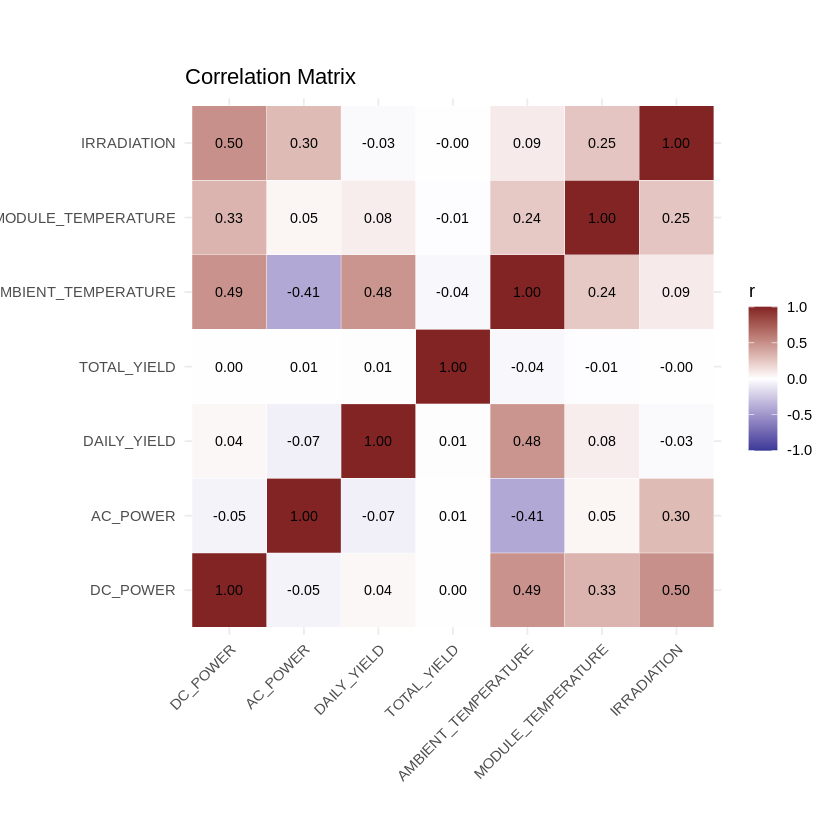

In [61]:
num_cols <- names(df)[sapply(df, is.numeric)]
corr_matrix <- cor(df[num_cols], use = "pairwise.complete.obs")

corr_series <- corr_matrix[, "DC_POWER"][-which(names(corr_matrix[, "DC_POWER"]) == "DC_POWER")]
corr_noAC   <- corr_series[names(corr_series) != "AC_POWER"]

corr_sorted <- sort(corr_noAC, decreasing = TRUE)
cat("\nCorrelation with DC_POWER (AC_POWER excluded):\n")
print(round(corr_sorted, 3))

corr_melt <- melt(corr_matrix)

ggplot(corr_melt, aes(Var1, Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low  = muted("blue"),
                       mid  = "white",
                       high = muted("red"),
                       midpoint = 0,
                       limits   = c(-1, 1)) +
  coord_equal() +
  geom_text(aes(label = sprintf("%.2f", value)), size = 3) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Correlation Matrix",
       x = NULL, y = NULL, fill = "r")

**3)** Which predictor was chosen??

In [62]:
top_feat <- names(corr_sorted)[1]
cat(sprintf("\nChosen predictor: %s  (r = %.3f)\n", top_feat, corr_sorted[top_feat]))



Chosen predictor: IRRADIATION  (r = 0.499)


### Regression

Regression is a core statistical method to fit the relationship between variables, enabling us to see the impact of changes in one variable on another. It is of immense importance in predicting the outcomes, the discovery of patterns, and facilitation of data-driven decision-making in numerous applications.

**1)** Write code to split your dataset into training test set using the highest‑correlated predictor and the target variable.

In [63]:
X <- df[top_feat]
y <- df$DC_POWER

set.seed(42)

train_idx <- sample(seq_len(nrow(df)), size = 0.75 * nrow(df))

X_train <- X[train_idx, , drop = FALSE]
y_train <- y[train_idx]
train_df  <- df[train_idx, ]

X_test  <- X[-train_idx, , drop = FALSE]
y_test  <- y[-train_idx]
test_df   <- df[-train_idx, ]

cat("Train size:", nrow(X_train), "| Test size:", nrow(X_test), "\n")

Train size: 51580 | Test size: 17194 


**2)** How would you construct and evaluate a simple linear regression model??

In [64]:
fmla <- as.formula(paste("DC_POWER ~", top_feat))
slr <- lm(fmla, data = df)
summary(slr)


Call:
lm(formula = fmla, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8604.6 -2064.4   -90.6  2261.7  9111.3 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2393.96      20.19   118.6   <2e-16 ***
IRRADIATION  5083.83      33.67   151.0   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2921 on 68772 degrees of freedom
Multiple R-squared:  0.249,	Adjusted R-squared:  0.2489 
F-statistic: 2.28e+04 on 1 and 68772 DF,  p-value: < 2.2e-16


**3)** Assess the performance of the fitted SLR model on both training and test data using R² and RMSE.

In [65]:

train_pred <- predict(slr, newdata = train_df)
test_pred  <- predict(slr, newdata  = test_df)

## 5. Metrics
train_met <- caret::postResample(train_pred, train_df$DC_POWER)
test_met  <- caret::postResample(test_pred,  test_df$DC_POWER)

cat(sprintf("Train  R²: %.3f | RMSE: %.0f\n", train_met["Rsquared"], train_met["RMSE"]))
cat(sprintf("Test   R²: %.3f | RMSE: %.0f\n",  test_met["Rsquared"],  test_met["RMSE"]))


Train  R²: 0.247 | RMSE: 2924
Test   R²: 0.254 | RMSE: 2912


**4)**  
a)Create a full set of diagnostic visuals for your SLR model.

b) Give your thoughts about the visual representations. Does your model violate any OLS assumptions? (1 point.)

`geom_smooth()` using formula = 'y ~ x'


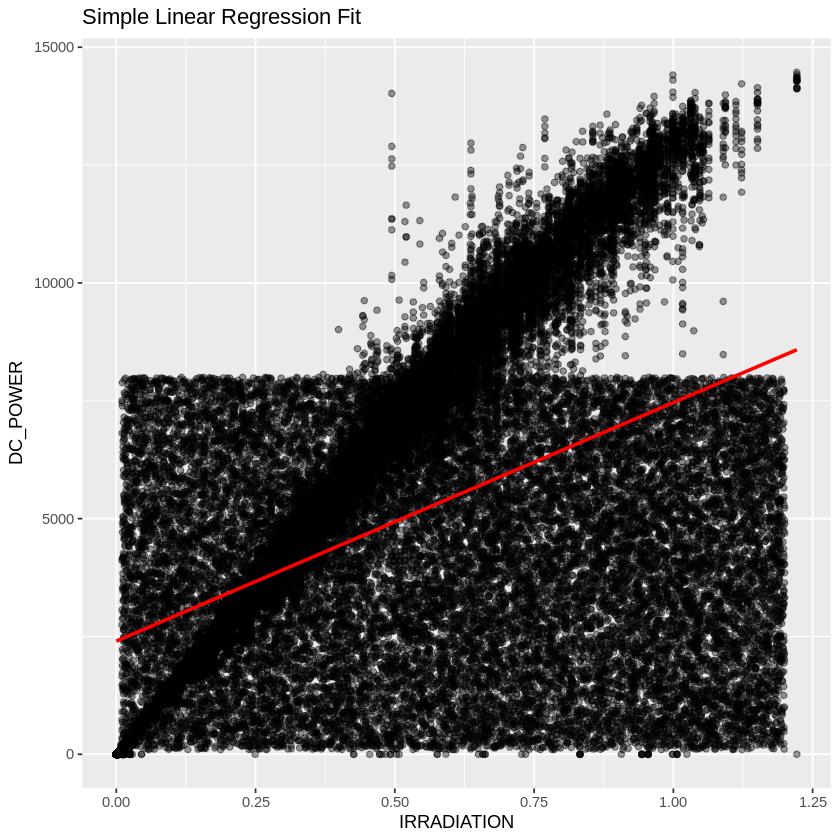

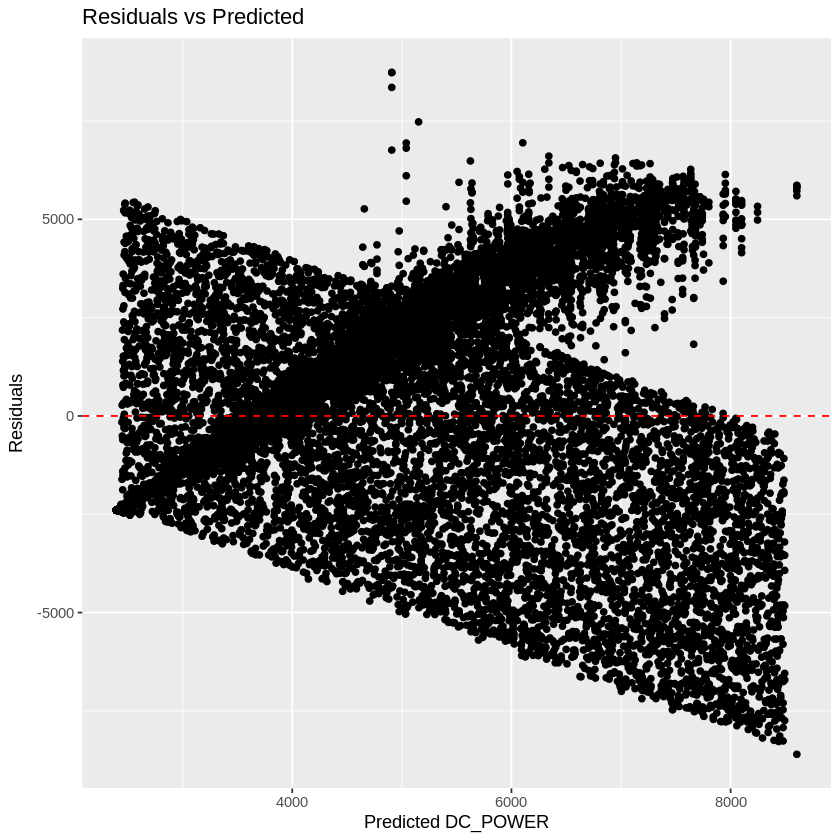

[1] 8542 8541

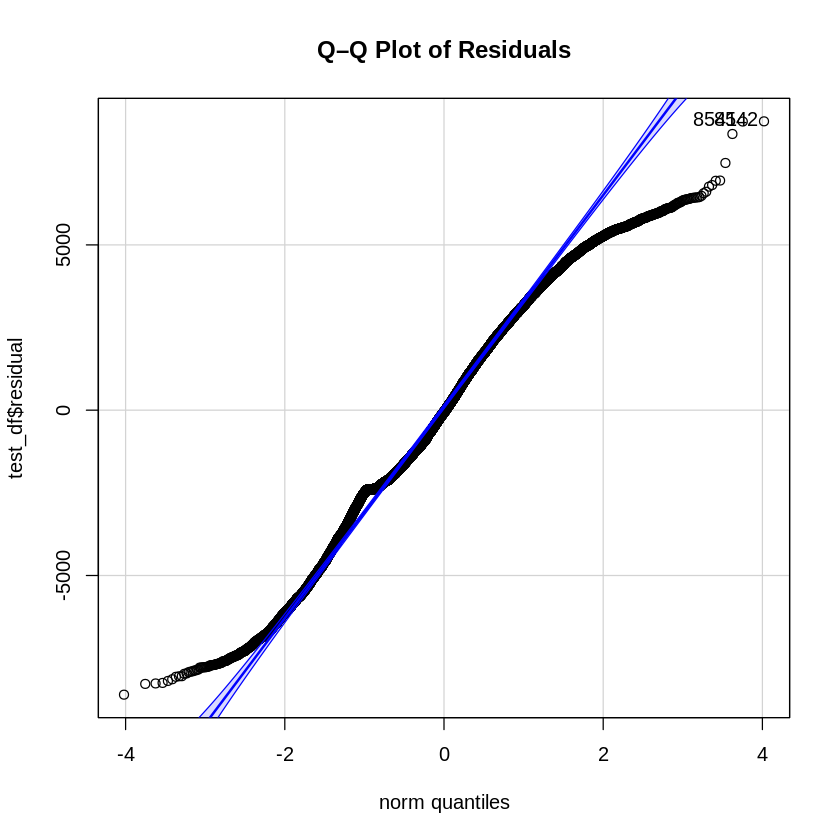

In [66]:
ggplot(train_df, aes_string(x = top_feat, y = "DC_POWER")) +
  geom_point(alpha = 0.4) +
  geom_smooth(method = "lm", se = FALSE, colour = "red") +
  labs(
    title = "Simple Linear Regression Fit",
    x = top_feat,
    y = "DC_POWER"
  )


test_df$predicted <- test_pred
test_df$residual  <- test_df$DC_POWER - test_df$predicted

ggplot(test_df, aes(predicted, residual)) +
  geom_point() +
  geom_hline(yintercept = 0, colour = "red", linetype = "dashed") +
  labs(
    title = "Residuals vs Predicted",
    x = "Predicted DC_POWER",
    y = "Residuals"
  )


qqPlot(test_df$residual, main = "Q–Q Plot of Residuals")


In [67]:
#enter your inferences here(use markdown box type)

Based on the diagnostic plots:

1.  **Simple Linear Regression Fit:** The plot shows a general upward trend, indicating a positive relationship between IRRADIATION and DC_POWER, which aligns with the positive correlation observed earlier. However, the spread of the points around the line is quite large, suggesting that IRRADIATION alone does not fully explain the variability in DC_POWER. There's also a noticeable cluster of points around DC_POWER = 0, which might be related to the data filtering or times when the plant is not generating power.

2.  **Residuals vs Predicted:** The residuals plot shows a non-random pattern. The residuals are not evenly scattered around zero across the range of predicted values. This suggests that the assumption of homoscedasticity (constant variance of residuals) is violated. The spread of residuals appears to increase as the predicted DC_POWER increases. There is also a curved pattern in the residuals, indicating that a linear model might not be the best fit for the data.

3.  **Q-Q Plot of Residuals:** The Q-Q plot shows that the residuals deviate significantly from the theoretical normal distribution line, especially at the tails. This indicates that the assumption of normality of residuals is violated.

**Conclusion about OLS Assumptions:**

Based on the visual representations, the simple linear regression model violates the assumptions of homoscedasticity and normality of residuals. The non-linear pattern in the residuals also suggests a violation of the linearity assumption. This indicates that a simple linear regression model with only IRRADIATION as a predictor is likely not the best fit for this data and a more complex model may be needed.